This notebook is based on the examples in https://github.com/fonnesbeck/Bios8366/blob/master/notebooks/Section5_2-Dirichlet-Processes.ipynb.

In [16]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import matplotlib.mlab as mlab
import math
from __future__ import division
import itertools

## Stick-breaking Process

A generative approach for allocating observations to groups is the stick-breaking process, which involves breaking the support of a particular variable into $k$ disjoint segments. Here, we start with a "stick" of unit length. To "break" the stick, we generate random points along the stick via the following algorithm:

1. generate a random variable $\beta_1 \sim Beta(1, \alpha_0)$
2. use this random variable (which is on the unit interval) to define a break point on the stick
3. iterate $k-1$ times:
    - generate $\beta_i \sim Beta(1, \alpha_0)$
    - identify next break point at $\pi_i = \beta_i \prod_{j=1}^{i-1} (1-\beta_j)$ (which is on the part of the stick that remains after the previous break)

This results in the creation of $k$ "pieces". Associated with each piece is a probability that is proportional to its length; these $k$ probabilities will have a Dirichlet distribution -- thus, the DP is a distribution over distributions. 

This process defines an **exchangeable** distribution on partitions of the stick; though there is an order to the generation of the segments, the distribution is independent of order.

Notice that $k$ can be infinite, making $G$ an infinite mixture.

In [17]:
def stick_breaking(alpha, k):
    betas = beta(1, alpha, k)
    remaining_pieces = np.append(1, np.cumprod(1 - betas[:-1]))
    p = betas * remaining_pieces
    return p/p.sum()

In [18]:
def dirichlet_process(p, H=np.random.randn):
    theta = H(len(p))
    return theta, p

In [19]:
def plot_G(alphas, k, theta, p):

alpha = 1
k = 1000
theta, p = dirichlet_process(stick_breaking(alpha, k))

    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,4))
    plt.bar(theta, p, width=0.001)
    plt.xlabel(r'$\theta_k$', fontsize=16)
    plt.ylabel(r'$\pi_k$', fontsize=16)

IndentationError: expected an indented block (<ipython-input-19-202e7718e7c1>, line 3)

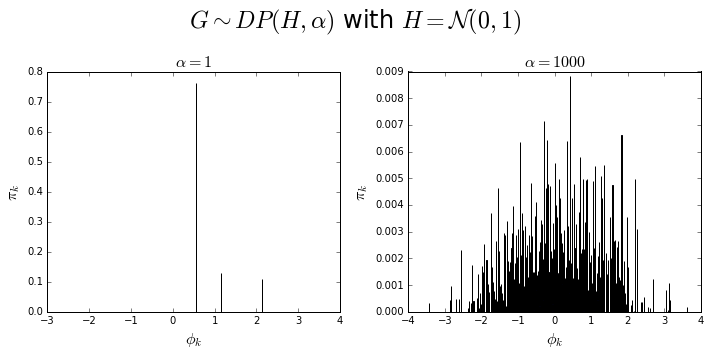

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
label_size = 16
k = 1000

alpha = 1
theta, p = dirichlet_process(stick_breaking(alpha, k))

axes[0].bar(theta, p, width=0.001)
axes[0].set_xlabel(r'$\phi_k$', fontsize=label_size)
axes[0].set_ylabel(r'$\pi_k$', fontsize=label_size)
axes[0].set_title(r'$\alpha=1$', fontsize=label_size)

alpha = 1000
theta, p = dirichlet_process(stick_breaking(alpha, k))

axes[1].bar(theta, p, width=0.001)
axes[1].set_xlabel(r'$\phi_k$', fontsize=label_size)
axes[1].set_ylabel(r'$\pi_k$', fontsize=label_size)
axes[1].set_title(r'$\alpha=1000$', fontsize=label_size)

plt.tight_layout()

plt.suptitle(r'$G \sim DP(H, \alpha)$ with $H=\mathcal{N}(0,1)$', fontsize=24)
plt.subplots_adjust(top=0.80)
plt.savefig('../figures/dp_samples_stick.pdf')

In [152]:
def sample_G(theta, p, n):
    return np.random.choice(theta, size=n, p=p)

In [106]:
def plot_dp(n, k, alpha):
    
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,4))
    for ax in np.ravel(axes):

        p = stick_breaking(alpha, k)
        dp = dp_stick(p, n)

        ax.hist(dp, 100)
        # ax.set_ylim([0, 110])
        ax.set_xlim([-2, 2])
        ax.grid()    
            
    fig.text(0.5, 0.01, r'$\theta$', ha='center', fontsize=16)
    fig.text(0.08, 0.5, 'Counts', va='center', rotation='vertical', fontsize=16)
    plt.suptitle(r'Stick-breaking', fontsize=24)

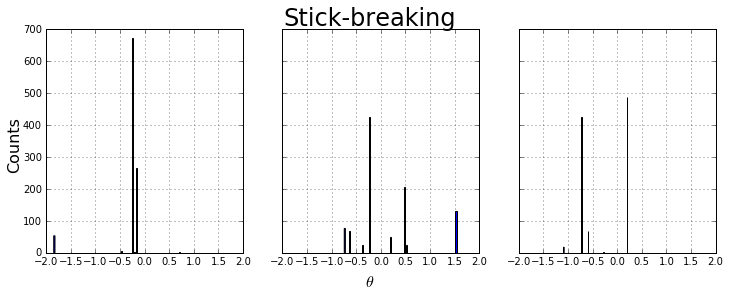

In [107]:
plot_dp(1000, 1000000, 1)

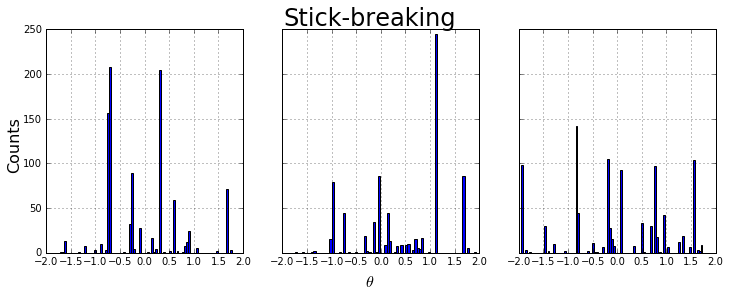

In [108]:
plot_dp(1000, 1000000, 10)

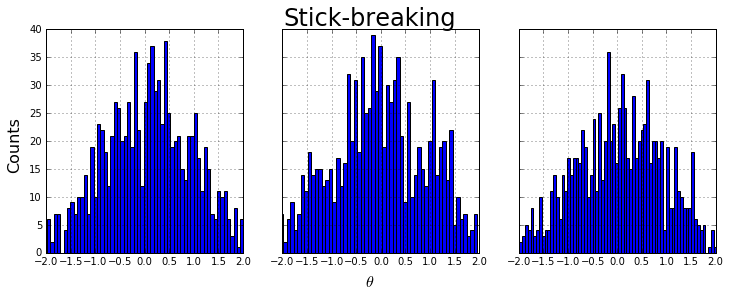

In [109]:
plot_dp(1000, 10000, 1000)

Notice that, while the particular values of the DP realizations are continuous, the distribution is discrete. But, as $\alpha \rightarrow \infty$, the likelihood of indexing the same $\theta_h$ more than once goes to zero, and one is essentially drawing from $P_0$.

So, while the DP is of limited use as a direct prior of a data distribution, it is extremely useful as a prior for an unknown mixture.

If we generalize the above approach such that the DP is used as the mixture measure for some kernel $\mathcal{K}(y|\theta)$, then we can define the mixture model:

$$f(y) = \sum_{h=1}^{\infty} \pi_h \mathcal{K}(y|\theta_h)$$

This is no different than other mixture models we have seen, except that the number of components is infinite. In practice, almost all the components are empty when we consider using it to model a finite dataset, but the model has the capacity to increase the number of mixture components as data are added.

This model can be specified hierarchically by:

$$\begin{aligned}
P &\sim DP(\alpha P_0) \\
\theta_i &\sim P \\
y_i &\sim \mathcal{K}(y|\theta_i)
\end{aligned}$$

The computational hurdle is in how to characterize the mixture when we cannot generate infinite mixture components. For this, we will use another generative model metaphor, the *Chinese restaurant process*.

In [32]:
def chinese_restaurant_process(n, alpha):
    
    if n < 1:
        return None
    
    table_assignments = np.empty(n)
    next_table = 0
    
    for c in range(n):
        if np.random.random() < (1. * alpha / (alpha + c)): # sit at new table
            table_assignments[c] = next_table
            next_table += 1            
        else: # assign to existing tables
            probs = [(table_assignments[:c]==i).sum()/float(c) 
                     for i in range(next_table)]
            table_assignments[c] = choice(range(next_table), p=probs)

    return table_assignments

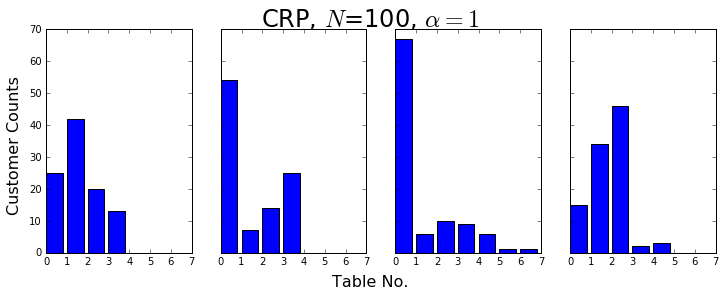

In [178]:
n = 100
alpha = 1

def plot_crp(table_nums, ax=None):
    x = list(range(int(table_nums.max()) + 1))
    f = [(table_nums==i).sum() for i in set(table_nums)]
    if ax is None: ax = plt
    ax.bar(x, f)
    
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12,4))
for ax in np.ravel(axes):
    plot_crp(chinese_restaurant_process(n, alpha), ax=ax)
fig.text(0.5, 0.01, 'Table No.', ha='center', fontsize=16)
fig.text(0.08, 0.5, 'Customer Counts', va='center', rotation='vertical', fontsize=16)
plt.suptitle(r'CRP, $N$=100, $\alpha=1$', fontsize=24)
plt.savefig('../figures/crp1.pdf')

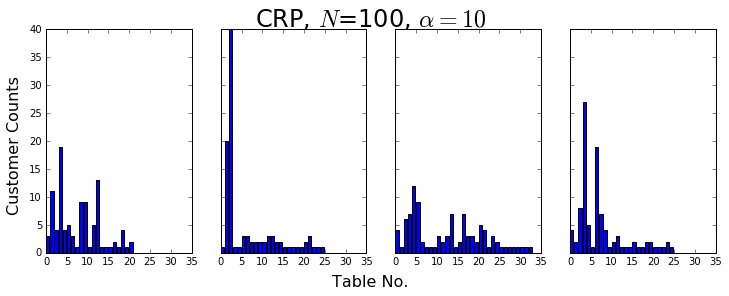

In [179]:
alpha = 10

fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12,4))
for ax in np.ravel(axes):
    plot_crp(chinese_restaurant_process(n, alpha), ax=ax)
fig.text(0.5, 0.01, 'Table No.', ha='center', fontsize=16)
fig.text(0.08, 0.5, 'Customer Counts', va='center', rotation='vertical', fontsize=16)
plt.suptitle(r'CRP, $N$=100, $\alpha=10$', fontsize=24)
plt.savefig('../figures/crp2.pdf')

In [4]:
class Hdp(object):
    def __init__(self,concentration,base):
        self.concentration = concentration
        self.base = base
        self.samples = []
        self.N = 0

    def sample(self):
        u = np.random.rand()
        if u<(self.concentration/(self.concentration + self.N)):
            # Sample from the base
            new_value = self.base.sample()
            self.samples.append(new_value)
            self.N += 1
        else:
            pos = np.random.randint(0,high=self.N)
            new_value = self.samples[pos]
            self.samples.append(new_value)
            self.N += 1
        return new_value

    def multiple_sample(self,N):
        samples = []
        for i in range(N):
            samples.append(self.sample())
        return samples

In [5]:
class Gauss(object):
    def __init__(self,mu,ss):
        self.mu = mu
        self.ss = ss
    def sample(self):
        # For random samples from N(\mu, \sigma^2), use:
        # sigma * np.random.randn(...) + mu
        u = np.random.randn()*np.sqrt(self.ss) + self.mu
        return u

# Single-level DP

In [12]:
alpha = 1
n_files = 1
n_j = 20

h = Hdp(alpha, Gauss(0, 10))
sub = []
all_samps = []
for i in range(n_files):
    sub.append(Hdp(alpha, h))
for i in range(n_files):
    all_samps.append(np.array(sub[i].multiple_sample(n_j)))

In [13]:
colors = itertools.cycle(['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w'])
colormap = {}
unique = sorted(list(set(h.samples)))
for val in unique:
    colormap[val] = next(colors)
print unique

[-0.86516677084821647, 2.6413880159135523]


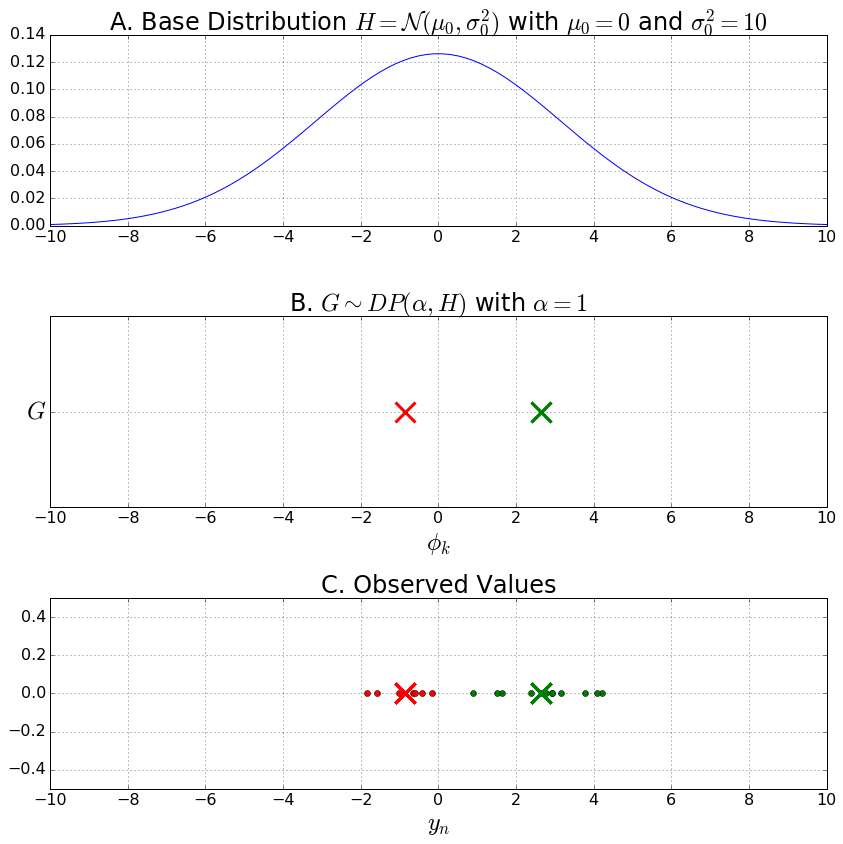

In [28]:
plt.figure(figsize=(12, 12))

ax = plt.subplot(3, 1, 1)
mu = 0
variance = 10
sigma = math.sqrt(variance)
x = np.linspace(-10, 10, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma))
plt.xticks(np.arange(-10, 12, 2))
plt.title(r'A. Base Distribution $H=\mathcal{N}(\mu_0,\sigma_0^2)$ with $\mu_0=0$ and $\sigma_0^2=10$', fontsize=24)
plt.grid()

ax = plt.subplot(3, 1, 2)
for x in h.samples:
    plt.plot(x, 0, 'x', markersize=20, color=colormap[x], mew=3)
    
plt.xlim([-10, 10])
plt.ylim([-0.5, 0.5])
plt.xticks(np.arange(-10, 12, 2))
plt.yticks(np.arange(0, 1, 1.0))
plt.xlabel(r'$\phi_k$', fontsize=24)
plt.title(r'B. $G \sim DP(\alpha, H)$ with $\alpha=1$', fontsize=24)
plt.grid()
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = r'$G$'
ax.set_yticklabels(labels, fontsize=24)

ax =  plt.subplot(3, 1, 3)
for j, sh in enumerate(sub):
    for x in sh.samples:
        val = x+np.random.randn()
        plt.plot(val, j, 'o', color=colormap[x])
        
for j, sh in enumerate(sub):
    for x in sh.samples:
        plt.plot(x, j, 'x', color=colormap[x], markersize=20, mew=3)        

plt.xlim([-10, 10])
plt.ylim([-0.5, 0.5]) 
plt.xticks(np.arange(-10, 12, 2))
plt.xlabel(r'$y_n$', fontsize=24)
plt.title(r'C. Observed Values', fontsize=24)
plt.grid()

font = {'size'   : 16}
matplotlib.rc('font', **font)

# plt.subplots_adjust(hspace=2)
plt.tight_layout()
plt.savefig('../figures/dp_samples.pdf')
plt.show()

# HDP

In [42]:
alpha = 1.0
n_files = 3
n_j = 40

h = Hdp(alpha, Gauss(0, 10))
sub = []
all_samps = []
for i in range(n_files):
    sub.append(Hdp(alpha, h))
for i in range(n_files):
    all_samps.append(np.array(sub[i].multiple_sample(n_j)))

In [43]:
print "Samples in top level DP"
print h.samples

for i in range(len(sub)):
    print "Samples in lower level DP {}".format(i)
    print all_samps[i]

Samples in top level DP
[6.5644670616024916, -1.1270007288718262, -3.9782663648930416, 6.5644670616024916, -1.1270007288718262, -1.1270007288718262, -1.1270007288718262, -1.1270007288718262, -1.1270007288718262, -1.1270007288718262, -3.9782663648930416, -1.1270007288718262]
Samples in lower level DP 0
[ 6.56446706  6.56446706  6.56446706  6.56446706  6.56446706  6.56446706
  6.56446706 -1.12700073  6.56446706  6.56446706  6.56446706  6.56446706
  6.56446706  6.56446706  6.56446706  6.56446706  6.56446706  6.56446706
  6.56446706  6.56446706  6.56446706  6.56446706  6.56446706  6.56446706
  6.56446706  6.56446706 -3.97826636  6.56446706 -1.12700073  6.56446706
  6.56446706 -1.12700073  6.56446706  6.56446706  6.56446706  6.56446706
  6.56446706 -1.12700073  6.56446706  6.56446706]
Samples in lower level DP 1
[-1.12700073 -1.12700073 -1.12700073 -1.12700073 -1.12700073 -1.12700073
 -1.12700073 -1.12700073 -1.12700073 -1.12700073 -1.12700073 -1.12700073
 -1.12700073 -1.12700073 -1.1270007

In [44]:
colors = itertools.cycle(['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w'])
colormap = {}
unique = sorted(list(set(h.samples)))
for val in unique:
    colormap[val] = next(colors)
print unique

[-3.9782663648930416, -1.1270007288718262, 6.5644670616024916]


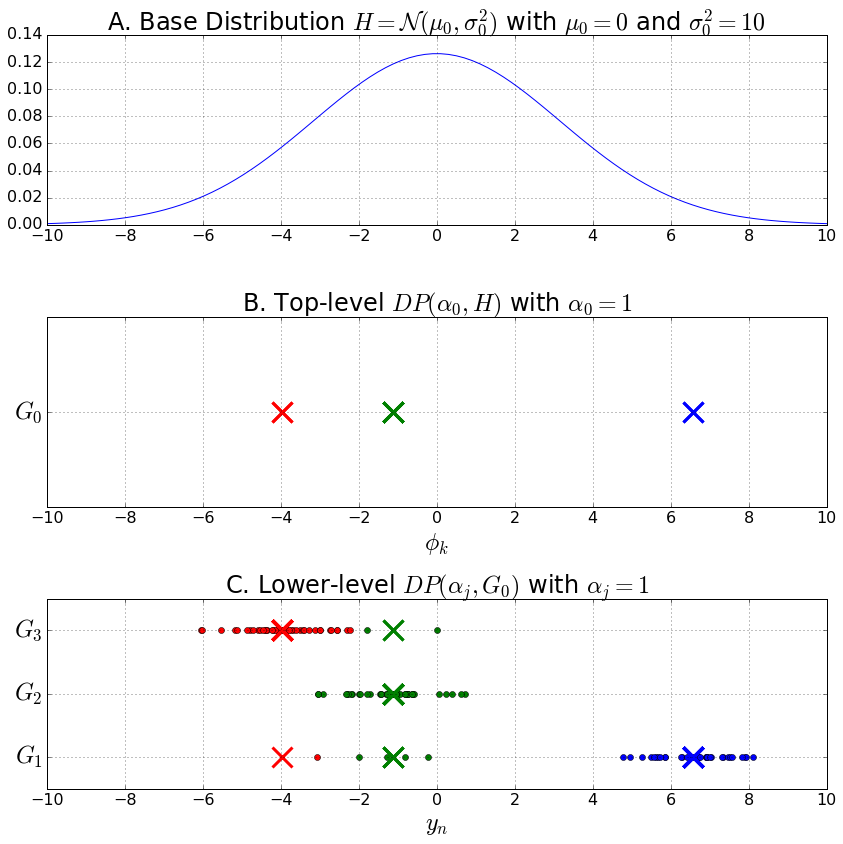

In [45]:
plt.figure(figsize=(12, 12))

ax = plt.subplot(3, 1, 1)
mu = 0
variance = 10
sigma = math.sqrt(variance)
x = np.linspace(-10, 10, 100)
plt.plot(x, mlab.normpdf(x, mu, sigma))
plt.xticks(np.arange(-10, 12, 2))
plt.title(r'A. Base Distribution $H=\mathcal{N}(\mu_0,\sigma_0^2)$ with $\mu_0=0$ and $\sigma_0^2=10$', fontsize=24)
plt.grid()

ax = plt.subplot(3, 1, 2)
for x in h.samples:
    plt.plot(x, 0, 'x', markersize=20, color=colormap[x], mew=3)
    
plt.xlim([-10, 10])
plt.ylim([-0.5, 0.5])
plt.xticks(np.arange(-10, 12, 2))
plt.yticks(np.arange(0, 1, 1.0))
plt.xlabel(r'$\phi_k$', fontsize=24)
plt.title(r'B. Top-level $DP(\alpha_0, H)$ with $\alpha_0=1$', fontsize=24)
plt.grid()
labels = [item.get_text() for item in ax.get_yticklabels()]
labels[0] = r'$G_0$'
ax.set_yticklabels(labels, fontsize=24)

ax =  plt.subplot(3, 1, 3)
for j, sh in enumerate(sub):
    for x in sh.samples:
        val = x+np.random.randn()
        plt.plot(val, j, 'o', color=colormap[x])
        
for j, sh in enumerate(sub):
    for x in sh.samples:
        plt.plot(x, j, 'x', color=colormap[x], markersize=20, mew=3)

plt.xlim([-10, 10])
plt.ylim([-0.5, 2.5]) 
plt.xticks(np.arange(-10, 12, 2))
plt.yticks(np.arange(0, 3, 1.0))
plt.xlabel(r'$y_n$', fontsize=24)
plt.title(r'C. Lower-level $DP(\alpha_j, G_0)$ with $\alpha_j=1$', fontsize=24)
plt.grid()
labels = [item.get_text() for item in ax.get_yticklabels()]
for i in range(len(labels)):
    labels[i] = r'$G_%d$' % (i+1)
ax.set_yticklabels(labels, fontsize=24)

font = {'size'   : 16}
matplotlib.rc('font', **font)

# plt.subplots_adjust(hspace=2)
plt.tight_layout()
plt.savefig('../figures/hdp_samples.pdf')
plt.show()